## Downloading the dataset from Kaggle



In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d anujms/car-damage-detection

 91% 112M/123M [00:00<00:00, 128MB/s] 
100% 123M/123M [00:00<00:00, 133MB/s]


## Unzipping the dataset

In [ ]:
!unzip /content/car-damage-detection.zip

Archive:  /content/car-damage-detection.zip
  inflating: data1a/training/00-damage/0001.JPEG  
  inflating: data1a/training/00-damage/0002.JPEG  
  inflating: data1a/training/00-damage/0003.JPEG  
  inflating: data1a/training/00-damage/0004.JPEG  
  inflating: data1a/training/00-damage/0005.JPEG  
  inflating: data1a/training/00-damage/0006.JPEG  
  inflating: data1a/training/00-damage/0007.JPEG  
  inflating: data1a/training/00-damage/0008.JPEG  
  inflating: data1a/training/00-damage/0009.JPEG  
  inflating: data1a/training/00-damage/0010.JPEG  
  inflating: data1a/training/00-damage/0011.JPEG  
  inflating: data1a/training/00-damage/0012.JPEG  
  inflating: data1a/training/00-damage/0013.JPEG  
  inflating: data1a/training/00-damage/0014.JPEG  
  inflating: data1a/training/00-damage/0015.JPEG  
  inflating: data1a/training/00-damage/0016.JPEG  
  inflating: data1a/training/00-damage/0017.JPEG  
  inflating: data1a/training/00-damage/0018.JPEG  
  inflating: data1a/training/00-damage

## Importing the necessary libraries and plotting one image

(168, 300, 3)


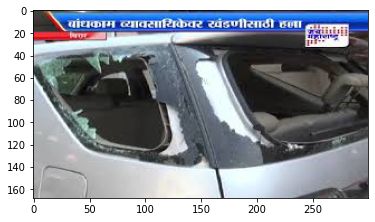

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
print(np.array(Image.open('/content/data1a/training/00-damage/0001.JPEG')).shape)
plt.imshow(np.array(Image.open('/content/data1a/training/00-damage/0001.JPEG')))

## Importing the necessary tensorflow packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam


Creating an augmentated dataset and setting the following parameters for augmentation

1. Rotation range: 20
2. Zoom:0.20
3. Width_shift_range: 0.2
4. Height_shift_range: 0.2
5. Creating a validation dataset of size 20%
6. Scaling the array pixels to a value between 0 and 1

Similarlly, we create a dataset for test and rescale the values





In [ ]:
augtrain=ImageDataGenerator(rescale=1. / 255,rotation_range=10,zoom_range=0.20,shear_range=0,horizontal_flip=False,width_shift_range=0.2,height_shift_range=0.2,validation_split=0.2)
augtest=ImageDataGenerator(rescale=1. / 255)

We need to read the images from the training folder and for that we can use the flow_from_directory package with the following parameters
1. Target size will convvert the images into a (150,150,3) array
2. Batch_size of 32 will create a batch of 32 while training the images
3. Shuffle will allow the model to generalize better
4. Subset will allow only 80% images to form training set
5. Class_mode set the classification to binary

Similarlly, we do it for the validation and test set

In [ ]:
train_generator=augtrain.flow_from_directory( directory = "/content/data1a/training",
       target_size = (150, 150),
       batch_size = 32,
        shuffle=True ,  
        subset='training' ,                                 
       class_mode = "binary",seed=0)

Found 1472 images belonging to 2 classes.


In [ ]:
val_generator=augtrain.flow_from_directory( directory = '/content/data1a/validation',
       target_size = (150,150),
       batch_size = 32,
      shuffle=True ,
      subset='validation',
       class_mode = "binary",seed=0)

Found 92 images belonging to 2 classes.


In [ ]:
test_generator=augtest.flow_from_directory( directory = '/content/data1a/validation',
       target_size = (150,150),
       batch_size = 32,
      shuffle=True ,
       class_mode = "binary",seed=0)

Found 460 images belonging to 2 classes.


To avoid any bias towards one class while training the model, we compute the class weights and pass them while training. As both classes have equal images the weights turn out to be equal

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',classes=np.unique(train_generator.labels),y=train_generator.labels)

In [ ]:
class_weight

array([1., 1.])

In [ ]:
w1=class_weight[0]
w2=class_weight[1]
class_weights={0:w1,1:w2}

For the model , we use the Transer learning VGG16 model and even though being a simple model, it has the ability to capture complex features. We set the input shape as (150,150,3) and the ending layers to be false as we will add our customized layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(include_top=False, input_shape=(150,150,3),weights='imagenet')

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

 We use the relu activation function and add the customized layers. The number of neurons keeps on decreasing to create a funnel while will help the model generalize better. A dropout of 0.3 is added to make the model data independent and memorize better.Finally a sigmoid at end to get binary classification

In [ ]:
model.output

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
model=Model(model.input,model.output)
f_model=tf.keras.Sequential(
    [
     model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=glorot_uniform(seed=0)),
     tf.keras.layers.Dropout(0.3,seed=0),
     tf.keras.layers.Dense(400, activation='relu',kernel_initializer=glorot_uniform(seed=0)),
     tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=glorot_uniform(seed=0)),

     
    ]
)

To increase the convergance speed of the model, an Adam optimizer is added and a learning rate which was manually tuned is set to 0.0001. At the first, the learning rate was set to 0.001 but this stuck the model at a local minima and the model could not get to the global minima. To avoid this, the learning rate was decreased. Four metrics have been used to evaluate the model performance: AUC,Precision,Recall and Accuracy

In [ ]:
from tensorflow.keras.metrics import AUC,Precision,Recall
f_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy',AUC(),Precision(),Recall()])

While training, I have added a checkpoint to save the model with the best validation accuracy. The training is for 15 epochs.

In [ ]:
model_checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)
history=f_model.fit(train_generator, epochs =15,class_weight=class_weights ,steps_per_epoch=train_generator.samples // 32,    validation_data = val_generator, 
    validation_steps = val_generator.samples //32,callbacks=[model_checkpoint])

Epoch 1/15
46/46 [==============================] - 28s 553ms/step - loss: 0.6202 - binary_accuracy: 0.6583 - auc_2: 0.7138 - precision_2: 0.6572 - recall_2: 0.6617 - val_loss: 0.4522 - val_binary_accuracy: 0.7812 - val_auc_2: 0.9194 - val_precision_2: 0.6977 - val_recall_2: 0.9677
Epoch 2/15
46/46 [==============================] - 25s 530ms/step - loss: 0.4661 - binary_accuracy: 0.7853 - auc_2: 0.8607 - precision_2: 0.7983 - recall_2: 0.7636 - val_loss: 0.2270 - val_binary_accuracy: 0.8906 - val_auc_2: 0.9775 - val_precision_2: 0.8750 - val_recall_2: 0.9032
Epoch 3/15
46/46 [==============================] - 24s 524ms/step - loss: 0.4438 - binary_accuracy: 0.8030 - auc_2: 0.8711 - precision_2: 0.8279 - recall_2: 0.7649 - val_loss: 0.4116 - val_binary_accuracy: 0.9219 - val_auc_2: 0.9312 - val_precision_2: 0.8621 - val_recall_2: 0.9615
Epoch 4/15
46/46 [==============================] - 22s 471ms/step - loss: 0.3452 - binary_accuracy: 0.8499 - auc_2: 0.9252 - precision_2: 0.8632 - rec

## Loading the best saved model

In [ ]:

from tensorflow.keras.models import load_model
saved_model = load_model('/content/checkpoints.h5')

In [ ]:
saved_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

## Evalutiing the model on the test dataset

The model gives a test accuracy of 90 percent

In [ ]:
saved_model.evaluate(test_generator,steps=test_generator.samples//32)

14/14 [==============================] - 3s 188ms/step - loss: 0.2440 - binary_accuracy: 0.9018


[0.2439657300710678, 0.9017857313156128]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Graphs for Training and Validation Accuracy and Loss

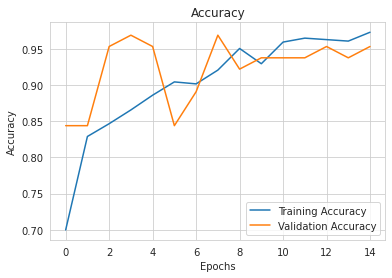

In [ ]:
plt.plot([i for i in range(0,15)],history.history['binary_accuracy'],label='Training Accuracy')
plt.plot([i for i in range(0,15)],history.history['val_binary_accuracy'],label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

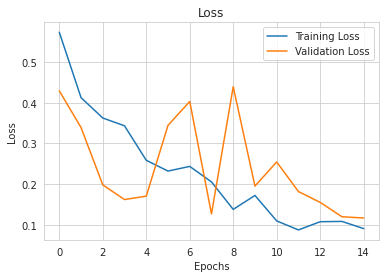

In [ ]:
plt.plot([i for i in range(0,15)],history.history['loss'],label='Training Loss')
plt.plot([i for i in range(0,15)],history.history['val_loss'],label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()